# Neural Networks on Processed Images

## Author: Alexander Goudemond, Student Number: 219030365

This notebook will follow a similar structure to 013 - trying to improve upon the benchmark both in terms of Mean IoU score, as well as appearance.

Our best models will then be used to generate videos - to show the predictions on other data - including test data!

Please ensure the following folders containg images exist:

drive > MyDrive > COMP700_Images > COMP700_Processed_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Processed_Training_ST

drive > MyDrive > COMP700_Images > COMP700_Raw_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Raw_Training_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_128_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_256_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_512_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_128_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_256_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_512_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_Processed_Images_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_Processed_Images_ST

------------------------------------------------------

Then, please ensure a seperate folder with the notebooks and text files exists:

drive > MyDrive > COMP700_Neural_Network_Code

------------------------------------------------------

The first 4 image folders were generated offline by the other notebooks and then uploaded to Google Drive, whereas the next 6 were generated by the notebook 011. The final 2 were generated by 015

In this notebook, we can reflect on the 6 models built in 016:

| Dataset | Model name                  | Patch Size | Mean IoU Score | Observations  |
|---------|-----------------------------|------------|----------------|--------------|
| GT      | UNET_Model_Dimension_256_1  | 256        | 0.306474       | Fuzzy |
| GT      | UNET_Model_Dimension_256_2  | 256        | 0.285340       | Mixed |
| GT      | UNET_Model_Dimension_256_3  | 256        | 0.343469       | Okay  |
|         |                             |            |                |       |
| ST      | UNET_Model_Dimension_256_1  | 256        | 0.641061       | Decent |
| ST      | UNET_Model_Dimension_256_2  | 256        | 0.706629       | Excellent|
| ST      | UNET_Model_Dimension_256_3  | 256        | 0.709928       | Excellent|

Similar to the results from 013, the ST dataset is scoring much better than the GT dataset. However, we also need to generate a prediction for 10 random images from both, to verify the observations. This is because our predictions may contain additional information - that the original masks do not - and so negative marking may apply


Recall that model 1 had 30 epochs and a batch size of 4, model 2 had 100 epochs and a batch size of 4 and model 3 had epochs and a batch size of 8

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from os import getcwd
google_drive_path = "/drive/MyDrive"
training_data_directory = getcwd() + google_drive_path + "/COMP700_Images/"

Please ensure the following folders containg images exist:

drive > MyDrive > COMP700_Images > COMP700_Processed_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Processed_Training_ST

drive > MyDrive > COMP700_Images > COMP700_Raw_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Raw_Training_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_128_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_256_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_512_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_128_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_256_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_512_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_Processed_Images_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_Processed_Images_ST

------------------------------------------------------

Then, please ensure a seperate folder with the notebooks and text files exists:

drive > MyDrive > COMP700_Neural_Network_Code

------------------------------------------------------

The first 4 image folders were generated offline by the other notebooks and then uploaded to Google Drive, whereas the next 6 were generated by the notebook 011. The final 2 were generated by 015

# Installs

In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [ ]:
from os import getcwd, walk, mkdir, stat, remove
from os import sep # used later on, in a function, to print directory contents
from os.path import exists, basename, join

from shutil import copyfile

from PIL.Image import fromarray
import cv2

import matplotlib.pyplot as plt
import numpy as np

from patchify import patchify, unpatchify

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input, Lambda
from keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.display import clear_output


# Useful functions

In [ ]:
def getImagePaths(path):
    image_paths = []
    for root, dirs, files in walk(path):
        if (len(files) != 0):
          # print(len(files))
          image_paths.append( root )

    image_paths.sort()

    return image_paths
###

In [ ]:
# returns tuple
def extractDirectoryPaths(path):
    x_directory_locations, y_directory_locations = [], []
    temp = ""

    with open(path) as f:
        lines = f.readlines()
        for item in lines:
            temp = item[ : -1] # remove newline char at end
            if ("X" in temp):
                x_directory_locations.append( temp ) 
            else:
                y_directory_locations.append( temp ) 

    return (x_directory_locations, y_directory_locations)
###

def loadImagePathsFromArray(array):
    image_paths = []

    for path in array:
        for root, dirs, files in walk(path):
            if (len(files) != 0):
                for item in files:
                    image_paths.append(root + "/" + item)

    image_paths.sort()

    return image_paths
###

In [ ]:
# assume cropped already
def patchifyIndividualImage(image, patch_size, isColourImage=True):
    scaler = MinMaxScaler()
    image_dataset = []

    print("Patchify process starting!")

    #Extract patches from each image
    if (isColourImage):
        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
    else:
        patches_img = patchify(image, (patch_size, patch_size), step=patch_size) # grayscale patchify
    
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i,j,:,:]
            
            #Use minmaxscaler instead of just dividing by 255. 
            single_patch_img = scaler.fit_transform(
                single_patch_img.reshape(-1, single_patch_img.shape[-1])
            ).reshape( single_patch_img.shape )
            
            #single_patch_img = (single_patch_img.astype('float32')) / 255. 
            #Drop the extra unecessary dimension that patchify adds. 
            single_patch_img = single_patch_img[0] 

            # scale up values - don't do this for the NN!
            # img_new = (single_patch_img * 255).astype(int) 
            img_new = single_patch_img

            image_dataset.append(img_new)

    print("Patchify process complete!")

    return image_dataset
###

In [ ]:
from tensorflow import keras
from keras.utils import array_to_img

def display(display_list, title=[], figsize=(15, 15)):
    plt.figure(figsize=figsize)

    # update if title not provided
    if (len(title) == 0):
      title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i], wrap=True)
        
        # handle 2D and 3D images
        if (len(display_list[i].shape) == 3 ):
            plt.imshow( array_to_img(display_list[i]), cmap="gray")
        else:
            plt.imshow( display_list[i], cmap="gray")
            
        plt.axis('off')
    plt.tight_layout() # prevents overlap
    plt.show()
###


In [ ]:
# create directories for work we create
def tryMakeDirectories(current_directory, myList):
    path = ""
    for item in myList:
        # initialize
        if (path == ""):
            path = item
        else:
            path = path + "/" + item
            
        try:
            # join comes from os.path
            mkdir( join(current_directory, path) )
        except FileExistsError:
            # print("Folder already exists!")
            pass
        except:
            print("Unknown Error Encountered...")
###

In [ ]:
def extractRhsString(string, symbol):
    index = string.rfind(symbol)
    return string[ index + len(symbol) : ]
###

def extractLhsString(string, symbol):
    index = string.find(symbol)
    return string[ : index ]
###

In [ ]:
def cropImage(image, patch_size):
    #Nearest size divisible by our patch size
    SIZE_X = (image.shape[1] // patch_size) * patch_size 
    SIZE_Y = (image.shape[0] // patch_size) * patch_size 

    image = fromarray(image)
    # Crop entire image into desirable shape
    image = image.crop((0 ,0, SIZE_X, SIZE_Y))  
    image = np.array(image)
    
    return image
###

# save and read all to ensure dtype=uint8
def readImage(img_path):
    image = plt.imread(img_path)
    plt.imsave("temp.png", image, cmap='gray')
    image = cv2.imread("temp.png")

    # try ensure 8 bit images used
    # x = x.astype(int)
    # y = np.array(x, dtype="uint8")

    return image
###
###

In [ ]:
def redesignImagePaths(array, directory_list):
    temp_2d_array = []
    temp_array = []
    count = 0
    next_directory = ""

    for path in array:
        # initialize
        if (count == 0):
            next_directory = directory_list[count]
            count += 1
        
        if (next_directory in path and count <= len(directory_list)):
            # print(path)
            # print(count)
            
            if (count < len(directory_list)):
                next_directory = directory_list[count]

            # place all contents into 2d array
            temp_2d_array.append(temp_array)

            temp_array = [] # reset
            count += 1 

        else:
            temp_array.append(path)

    # at end, append final list
    temp_2d_array.append(temp_array)  

    return temp_2d_array[ 1 : ] # remove dummy element

In [ ]:
from keras.utils import array_to_img

def convertFloatRGBtoBinary(img):
    plt.imsave("temp.png", img)
    gray = cv2.imread("temp.png", cv2.IMREAD_GRAYSCALE)

    if (exists("temp.png")):
        remove("temp.png")

    gray[gray < 255] = 0
    gray[gray == 255] = 1

    return gray.astype(float)
###

In [ ]:
def reshapePatchifiedImages(og_image, patches, height, width, patch_size, invert_scaling=True):
    # use original patchify to get integer slices of image
    collection = patchify(og_image, (patch_size, patch_size, 3), step=patch_size)
    counter = 0
    row_of_images, organised_patches = [], []

    # i * j == (patchifyIndividualImage(...).shape)[0]
    for i in range(height // patch_size):
        for j in range(width // patch_size):
            single_image = patches[counter]                   # 3D object

            # map to integer again?
            if (invert_scaling):
                # use og_image patches to find min and max ints
                min = np.min(collection[i,j,:,:][0])
                max = np.max(collection[i,j,:,:][0])
                single_image = (single_image * (max - min)) + min

            new_img = [single_image]                          # 4D object    
            
            row_of_images.append( new_img )

            counter += 1
        
        # print(len(row_of_images))
        organised_patches.append( row_of_images )             # stick rows ontop of one another
        row_of_images = [] 
    
    return organised_patches
###

In [ ]:
# crop
def bulkCrop(x_paths, y_paths, patch_size):
    cropped_x, cropped_y = [], []

    for i in range(len(x_paths)):
        cropped_x.append( cropImage( readImage(x_paths[i]), patch_size) )
        cropped_y.append( cropImage( readImage(y_paths[i]) , patch_size) )

    return cropped_x, cropped_y
###

In [ ]:
from keras.models import load_model

def getModel(path, model_name):
    return load_model(path + model_name)
###

In [ ]:
def patchifyAndPredict(image, model, patch_size, threshold=0.5):
    patchified_images = patchifyIndividualImage(image, patch_size=patch_size)

    patchified_images = np.array(patchified_images)
    patchified_predictions = model.predict(patchified_images)

    # adjust threshold here
    threshold = threshold
    patchified_predictions_thresh = patchified_predictions 
    patchified_predictions_thresh[patchified_predictions_thresh >= threshold] = 1
    patchified_predictions_thresh[patchified_predictions_thresh < threshold] = 0

    # fix colours - dont do this, for unpatchify process!
    # answer = []
    # for image in patchified_predictions_thresh:
    #     answer.append( convertFloatRGBtoBinary(image) )

    return patchified_predictions_thresh
###

In [ ]:
def rebuildImageFromPatches(og_image, image_patches, patch_size, invert_scaling=True):
    height, width, _ = np.array(og_image).shape
    

    redesigned_images = reshapePatchifiedImages(og_image, 
                                                image_patches, 
                                                height, 
                                                width, 
                                                patch_size, 
                                                invert_scaling=invert_scaling)
    # print(np.array(og_image).shape)
    # print(np.array(redesigned_images).shape)
    
    redesigned_images = np.array(redesigned_images)
    rebuilt_image = unpatchify(redesigned_images, np.array(og_image).shape)
    
    return rebuilt_image
###

In [ ]:
# expects images of patch_size
def conductPrediction(image, patch_size, path, model, threshold = 0.5, invert_scaling=True):

    predicted_patches = patchifyAndPredict(image, model, patch_size, threshold=threshold)

    rebuilt_image = rebuildImageFromPatches(image, 
                                            predicted_patches, 
                                            patch_size, 
                                            invert_scaling=invert_scaling
                                            )
    
    # fix colours and return
    return convertFloatRGBtoBinary(rebuilt_image)
###


def getBinaryClasses(mask_array):
    answer = []
    for image in mask_array:
        temp = image
        temp[temp > 0] = 1
        answer.append(temp)

    return answer
###

In [ ]:
from tensorflow import keras
from keras.utils import array_to_img

def display2DPlot(display_list, title, figsize=(15, 15)):
    plt.figure(figsize=figsize)
    counter = 0

    for i in range(len(display_list)):
        for j in range(len(display_list[0])):
            counter += 1
            plt.subplot(len(display_list), len(display_list[0]), counter)
            plt.title(title[i][j], wrap=True)
            
            # handle 2D and 3D images
            if (len(display_list[i][j].shape) == 3 ):
                plt.imshow( array_to_img(display_list[i][j]), cmap="gray")
            else:
                plt.imshow( display_list[i][j], cmap="gray")
                
            plt.axis('off')
            
        
        # print("i", i)

    plt.tight_layout() # prevents overlap
    plt.show()
###


In [ ]:
def conductBulkPrediction(cropped_x, cropped_y, patch_size, path, model_name, threshold=0.5):
    random_cropped_x, random_cropped_y =  bulkCrop(cropped_x, cropped_y, patch_size)
    random_cropped_y = getBinaryClasses(random_cropped_y) # doesnt impact preditions, used for visualizations only

    model = getModel(path, model_name)    # load model
    array, labels = [], []

    for i in range(len(random_cropped_x)):
        prediction = conductPrediction(random_cropped_x[i],
                                      patch_size = patch_size,
                                      path = path,
                                      model = model, 
                                      threshold = threshold,
                                      invert_scaling=False
                                      )
        
        array.append( [random_cropped_x[i], random_cropped_y[i], prediction] )
        labels.append( ["X_" + str(i+1), "Y_" + str(i+1), "Prediction_" + str(i+1)] )
    
    return array, labels
###

def save2DPlot(display_list, title, location, filename, figsize=(15, 15)):
    plt.figure(figsize=figsize)
    counter = 0

    for i in range(len(display_list)):
        for j in range(len(display_list[0])):
            counter += 1
            plt.subplot(len(display_list), len(display_list[0]), counter)
            plt.title(title[i][j], wrap=True)
            
            # handle 2D and 3D images
            if (len(display_list[i][j].shape) == 3 ):
                plt.imshow( array_to_img(display_list[i][j]), cmap="gray")
            else:
                plt.imshow( display_list[i][j], cmap="gray")
                
            plt.axis('off')
            
        
        # print("i", i)

    plt.tight_layout() # prevents overlap
    plt.savefig(location + filename)
###


# Loading GT and ST Training Data

Here, we can read in the contents of our desired text files and prepare them to be shuffled

In [ ]:
google_drive_path = "/drive/MyDrive"
text_file_location = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"

Extract and load Image

In [ ]:
filename = "processed_training_paths_gt.txt"
gt_x_image_paths, gt_y_image_paths = extractDirectoryPaths(text_file_location + filename)

gt_x_images = loadImagePathsFromArray(gt_x_image_paths)
gt_y_images = loadImagePathsFromArray(gt_y_image_paths)

if (len(gt_x_images) == len(gt_y_images)):
    print("Same quantity of images and masks!")
else:
    print("Not all pictures match...")

Same quantity of images and masks!


In [ ]:
filename = "processed_training_paths_st.txt"
st_x_image_paths, st_y_image_paths = extractDirectoryPaths(text_file_location + filename)

st_x_images = loadImagePathsFromArray(st_x_image_paths)
st_y_images = loadImagePathsFromArray(st_y_image_paths)

if (len(st_x_images) == len(st_y_images)):
    print("Same quantity of images and masks!")
else:
    print("Not all pictures match...")

Same quantity of images and masks!


In [ ]:
print("There are", len(st_x_images), "ST images and", len(gt_x_images), "GT images")

There are 7752 ST images and 578 GT images


Next, we need to partition the data, as we desire to select 1 image from each folder:

In [ ]:
gt_directory_list = []
temp = ""
count = 0

for path in gt_x_image_paths:
    if (count % 2 == 0):
        temp = extractRhsString(path, "GT/")
        temp = extractLhsString(temp, "/")
        # print(temp)
        gt_directory_list.append(temp)

    count += 1

gt_directory_list

['BF-C2DL-HSC',
 'BF-C2DL-MuSC',
 'DIC-C2DH-HeLa',
 'Fluo-C2DL-Huh7',
 'Fluo-C2DL-MSC',
 'Fluo-N2DH-GOWT1',
 'Fluo-N2DH-SIM+',
 'Fluo-N2DL-HeLa',
 'PhC-C2DH-U373',
 'PhC-C2DL-PSC']

In [ ]:
st_directory_list = []
temp = ""
count = 0

for path in st_x_image_paths:
    if (count % 2 == 0):
        temp = extractRhsString(path, "ST/")
        temp = extractLhsString(temp, "/")
        # print(temp)
        st_directory_list.append(temp)

    count += 1

st_directory_list

['BF-C2DL-HSC',
 'BF-C2DL-MuSC',
 'DIC-C2DH-HeLa',
 'Fluo-C2DL-MSC',
 'Fluo-N2DH-GOWT1',
 'Fluo-N2DL-HeLa',
 'PhC-C2DH-U373',
 'PhC-C2DL-PSC']

In [ ]:
gt_x_images = redesignImagePaths(gt_x_images, gt_directory_list)

len(gt_x_images)

10

In [ ]:
gt_y_images = redesignImagePaths(gt_y_images, gt_directory_list)

len(gt_y_images)

10

In [ ]:
st_x_images = redesignImagePaths(st_x_images, st_directory_list)

len(st_x_images)

8

In [ ]:
st_y_images = redesignImagePaths(st_y_images, st_directory_list)

len(st_y_images)

8

# Select random images

In [ ]:
from random import randint

random_gt_x_paths = []
random_gt_y_paths = []
index = 0
count = 0

for paths in gt_x_images:
    # print(paths)
    index = randint(0, len(paths)-1)

    random_gt_x_paths.append(gt_x_images[count][index])
    random_gt_y_paths.append(gt_y_images[count][index])

    count += 1 

count = 0
for i in range(len(random_gt_x_paths)):
    if (extractRhsString(random_gt_x_paths[i], "_t")[ : -4] 
        != 
        extractRhsString(random_gt_y_paths[i], "/man_seg")[ : -4] 
        ):
        count += 1

print(count, "image(s) do not match")

0 image(s) do not match


In [ ]:
from random import randint

random_st_x_paths = []
random_st_y_paths = []
index = 0
count = 0

for paths in st_x_images:
    # print(paths)
    index = randint(0, len(paths)-1)

    random_st_x_paths.append(st_x_images[count][index])
    random_st_y_paths.append(st_y_images[count][index])

    count += 1 

count = 0
for i in range(len(random_st_x_paths)):
    if (extractRhsString(random_gt_x_paths[i], "_t")[ : -4] 
        != 
        extractRhsString(random_gt_y_paths[i], "/man_seg")[ : -4] 
        ):
        count += 1

print(count, "image(s) do not match")

0 image(s) do not match


# GT 256 Models

In [ ]:
# make directories for images
image_path = getcwd() + google_drive_path + "/COMP700_Images/"

tryMakeDirectories(image_path, ["Matplotlib_Figures", "UNET_Model_Predictions_Processed"])

Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 3s 3s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 673ms/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 1s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 953ms/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 1s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 683ms/step
Patchify process starting!
Patchify process complete!
1

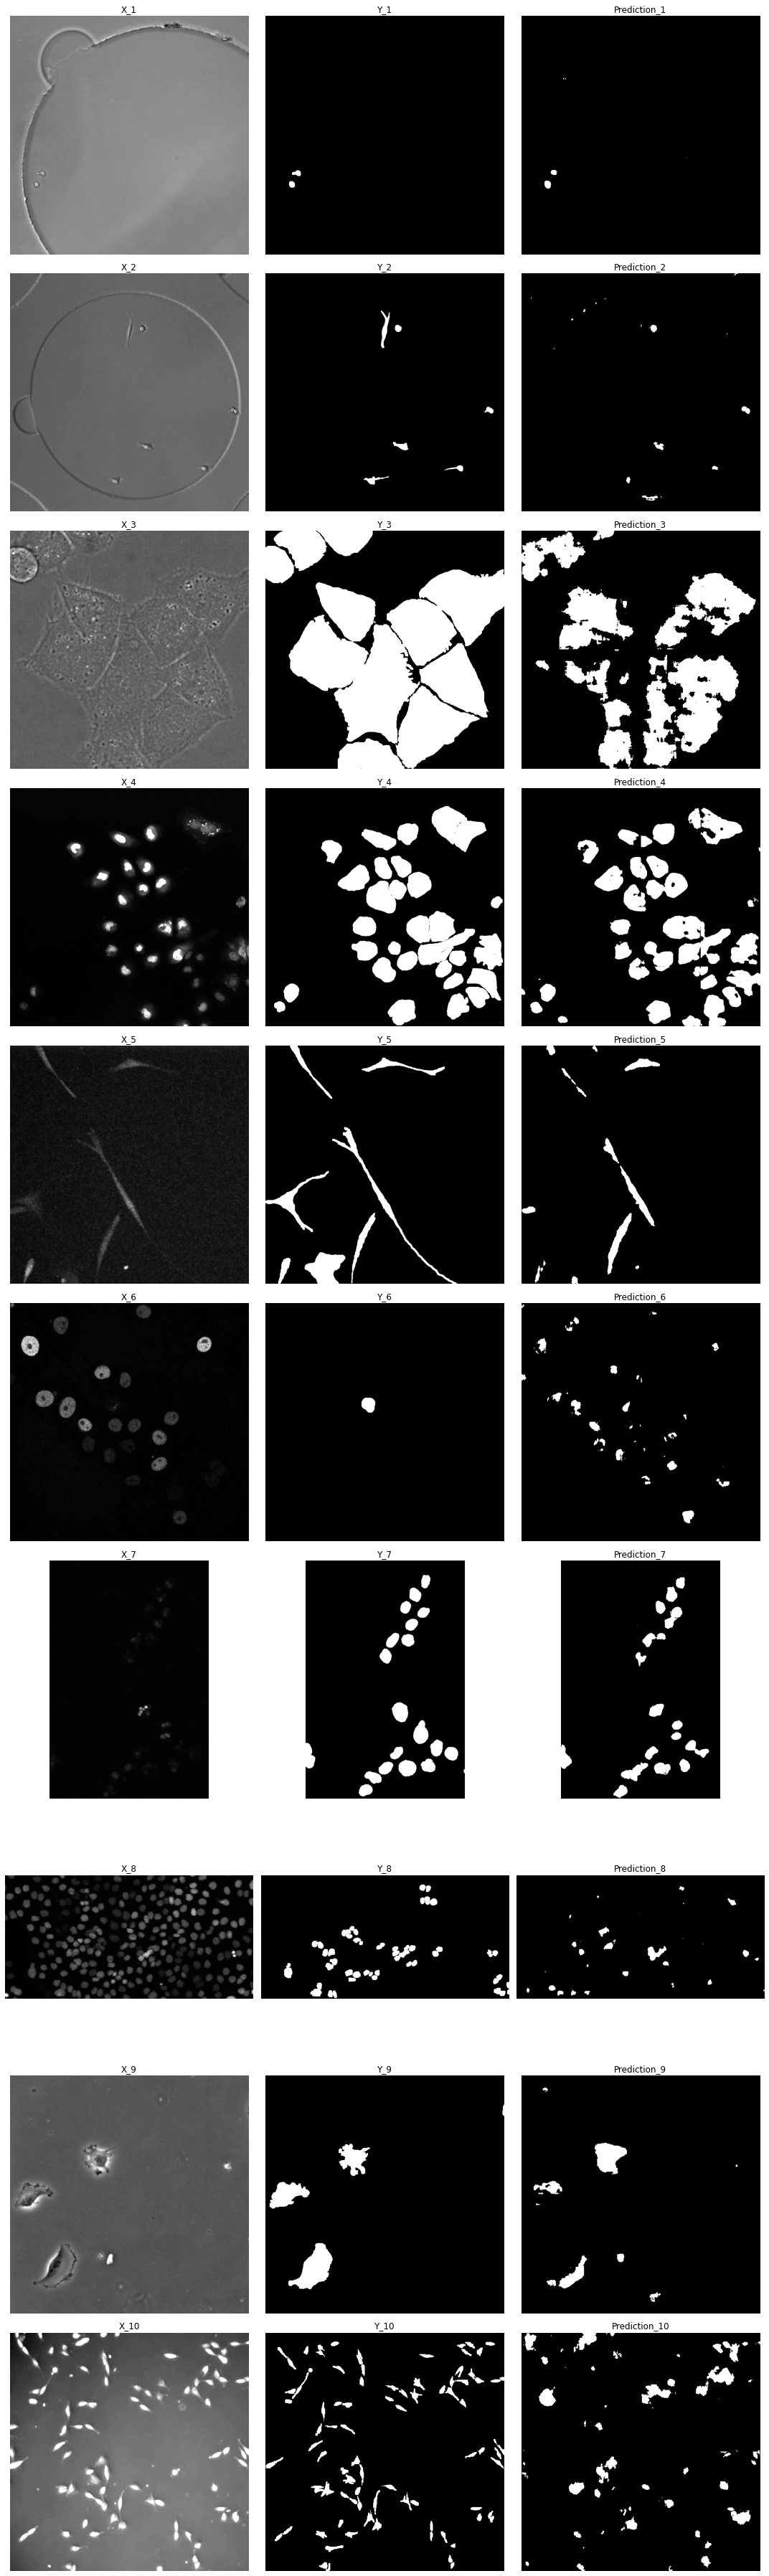

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/Processed_GT_256/"
model_name = "processed_gt_images_256_model_1"
patch_size = 256

array, labels = conductBulkPrediction(random_gt_x_paths, 
                                      random_gt_y_paths,
                                      patch_size = patch_size,
                                      path = path,
                                      model_name = model_name,
                                      threshold = 0.5
                                      )

location = "/content/drive/MyDrive/COMP700_Images/Matplotlib_Figures/UNET_Model_Predictions_Processed/"

save2DPlot(array, labels, location, model_name + "_predictions.png", figsize=(15,50))

Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 665ms/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 1s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 979ms/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 1s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 669ms/step
Patchify process starting!
Patchify process complete!
1

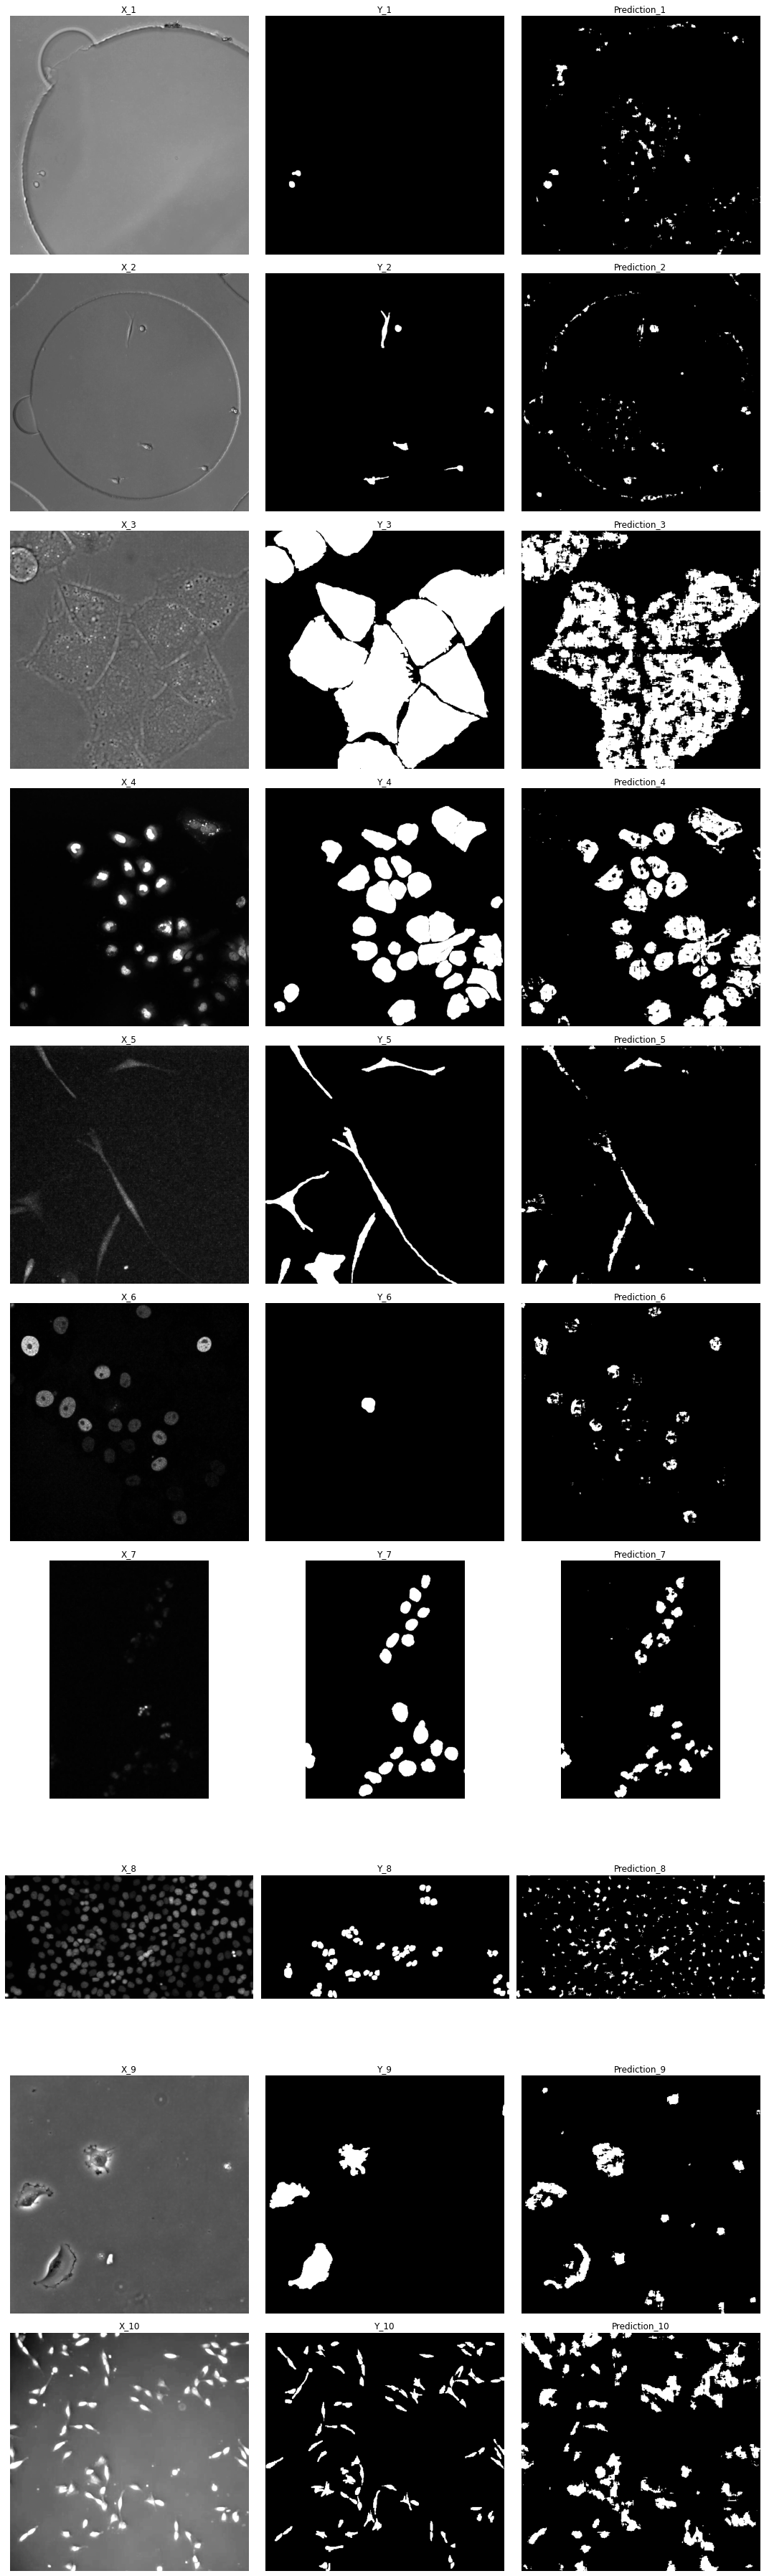

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/Processed_GT_256/"
model_name = "processed_gt_images_256_model_2"
patch_size = 256

array, labels = conductBulkPrediction(random_gt_x_paths, 
                                      random_gt_y_paths,
                                      patch_size = patch_size,
                                      path = path,
                                      model_name = model_name,
                                      threshold = 0.5
                                      )

location = "/content/drive/MyDrive/COMP700_Images/Matplotlib_Figures/UNET_Model_Predictions_Processed/"

save2DPlot(array, labels, location, model_name + "_predictions.png", figsize=(15,50))

Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 684ms/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 1s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 943ms/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 1s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 670ms/step
Patchify process starting!
Patchify process complete!
1

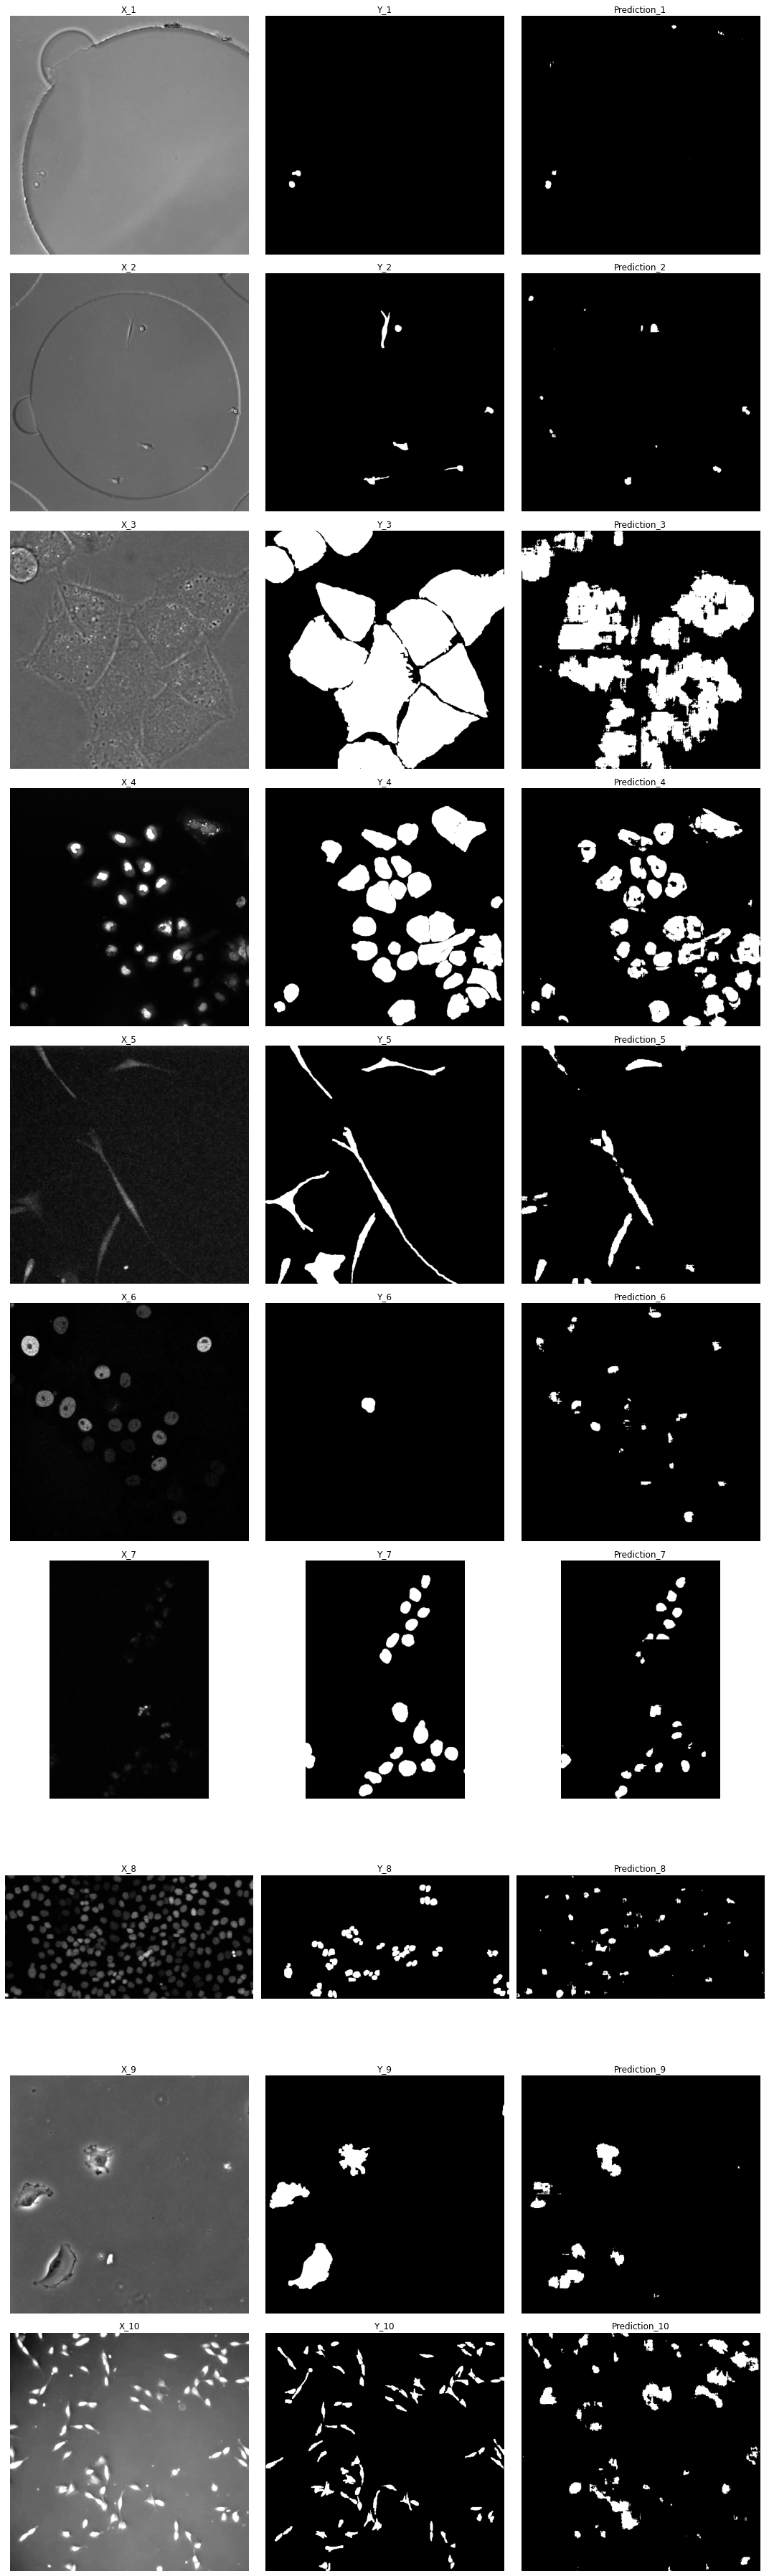

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/Processed_GT_256/"
model_name = "processed_gt_images_256_model_3"
patch_size = 256

array, labels = conductBulkPrediction(random_gt_x_paths, 
                                      random_gt_y_paths,
                                      patch_size = patch_size,
                                      path = path,
                                      model_name = model_name,
                                      threshold = 0.5
                                      )

location = "/content/drive/MyDrive/COMP700_Images/Matplotlib_Figures/UNET_Model_Predictions_Processed/"

save2DPlot(array, labels, location, model_name + "_predictions.png", figsize=(15,50))

# ST 256 Models

In [ ]:
# make directories for images
image_path = getcwd() + google_drive_path + "/COMP700_Images/"

tryMakeDirectories(image_path, ["Matplotlib_Figures", "UNET_Model_Predictions_Processed"])

Patchify process starting!
Patchify process complete!
1/1 [==============================] - 3s 3s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 657ms/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 1s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 959ms/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 1s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 651ms/step
Patchify process starting!
Patchify process complete!
1

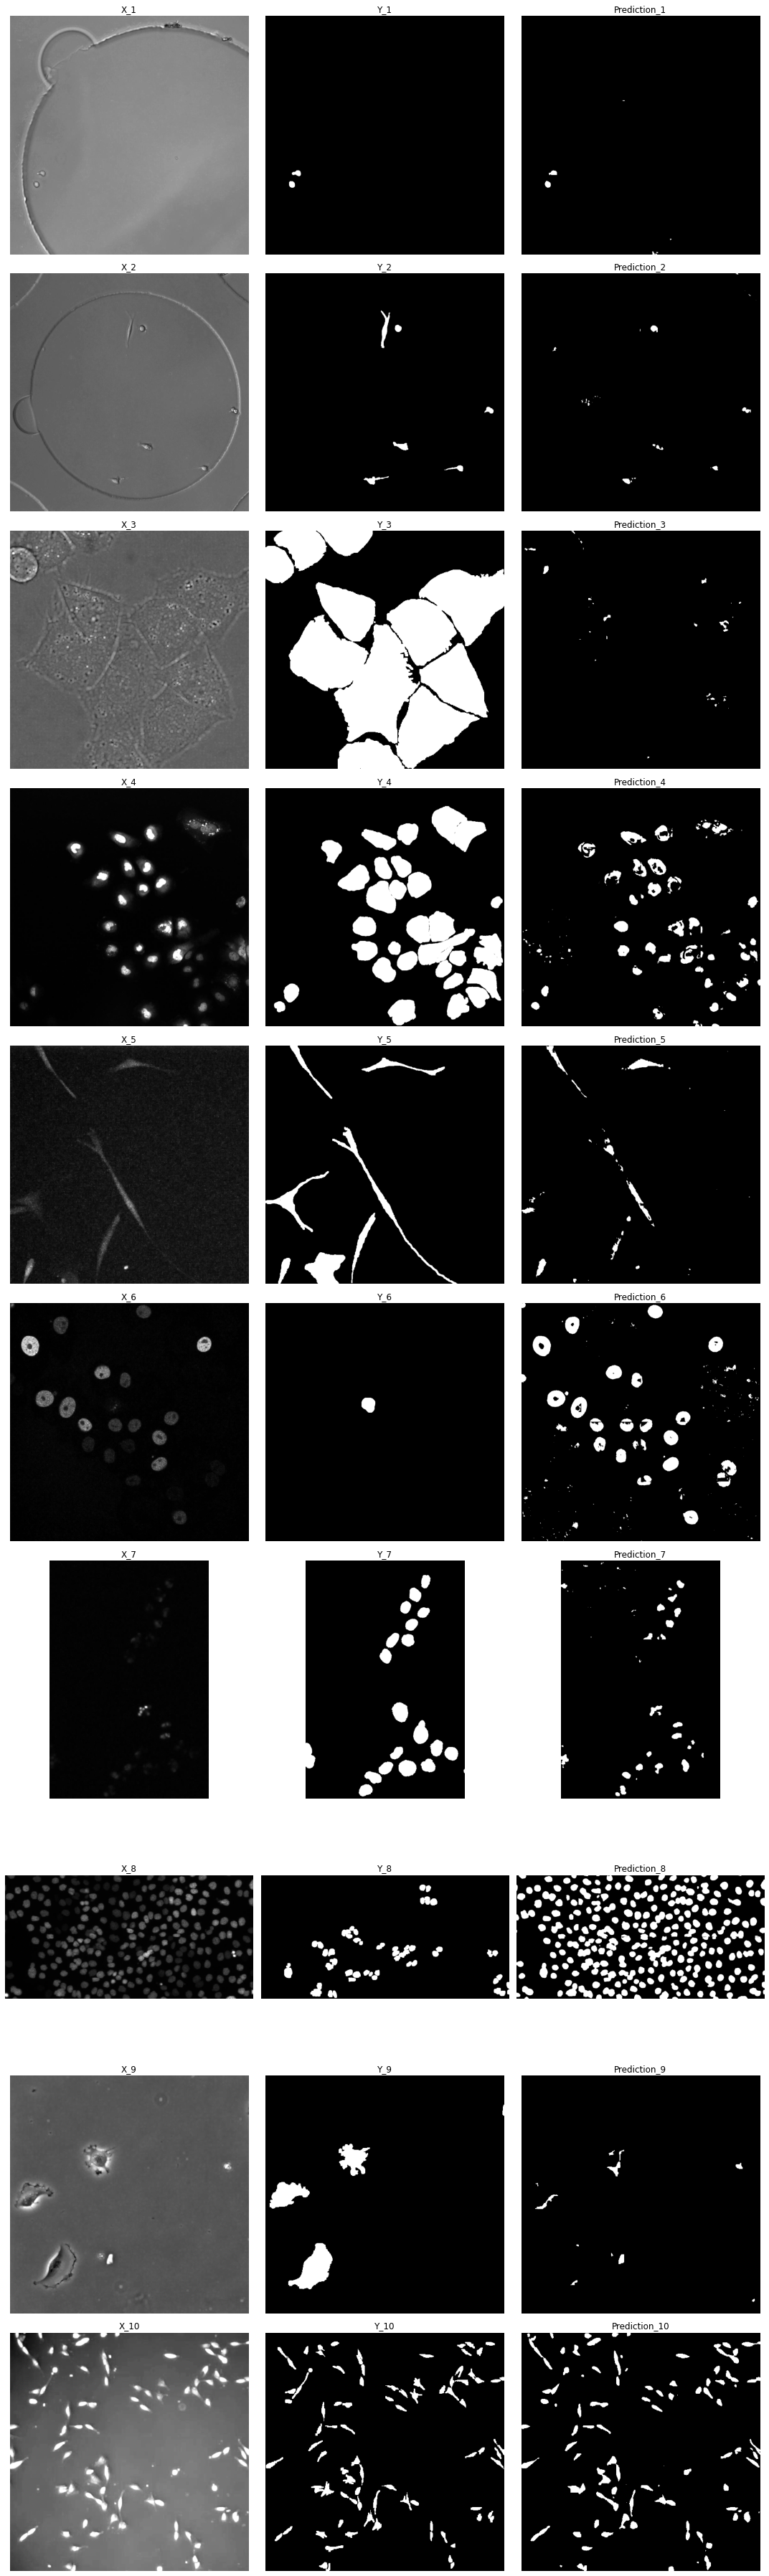

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/Processed_ST_256/"
model_name = "processed_st_images_256_model_1"
patch_size = 256

array, labels = conductBulkPrediction(random_gt_x_paths, 
                                      random_gt_y_paths,
                                      patch_size = patch_size,
                                      path = path,
                                      model_name = model_name,
                                      threshold = 0.5
                                      )

location = "/content/drive/MyDrive/COMP700_Images/Matplotlib_Figures/UNET_Model_Predictions_Processed/"

save2DPlot(array, labels, location, model_name + "_predictions.png", figsize=(15,50))

Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 3s 3s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 1s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 1s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 955ms/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 1s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 662ms/step
Patchify process starting!
Patchify process complete!
1/1 

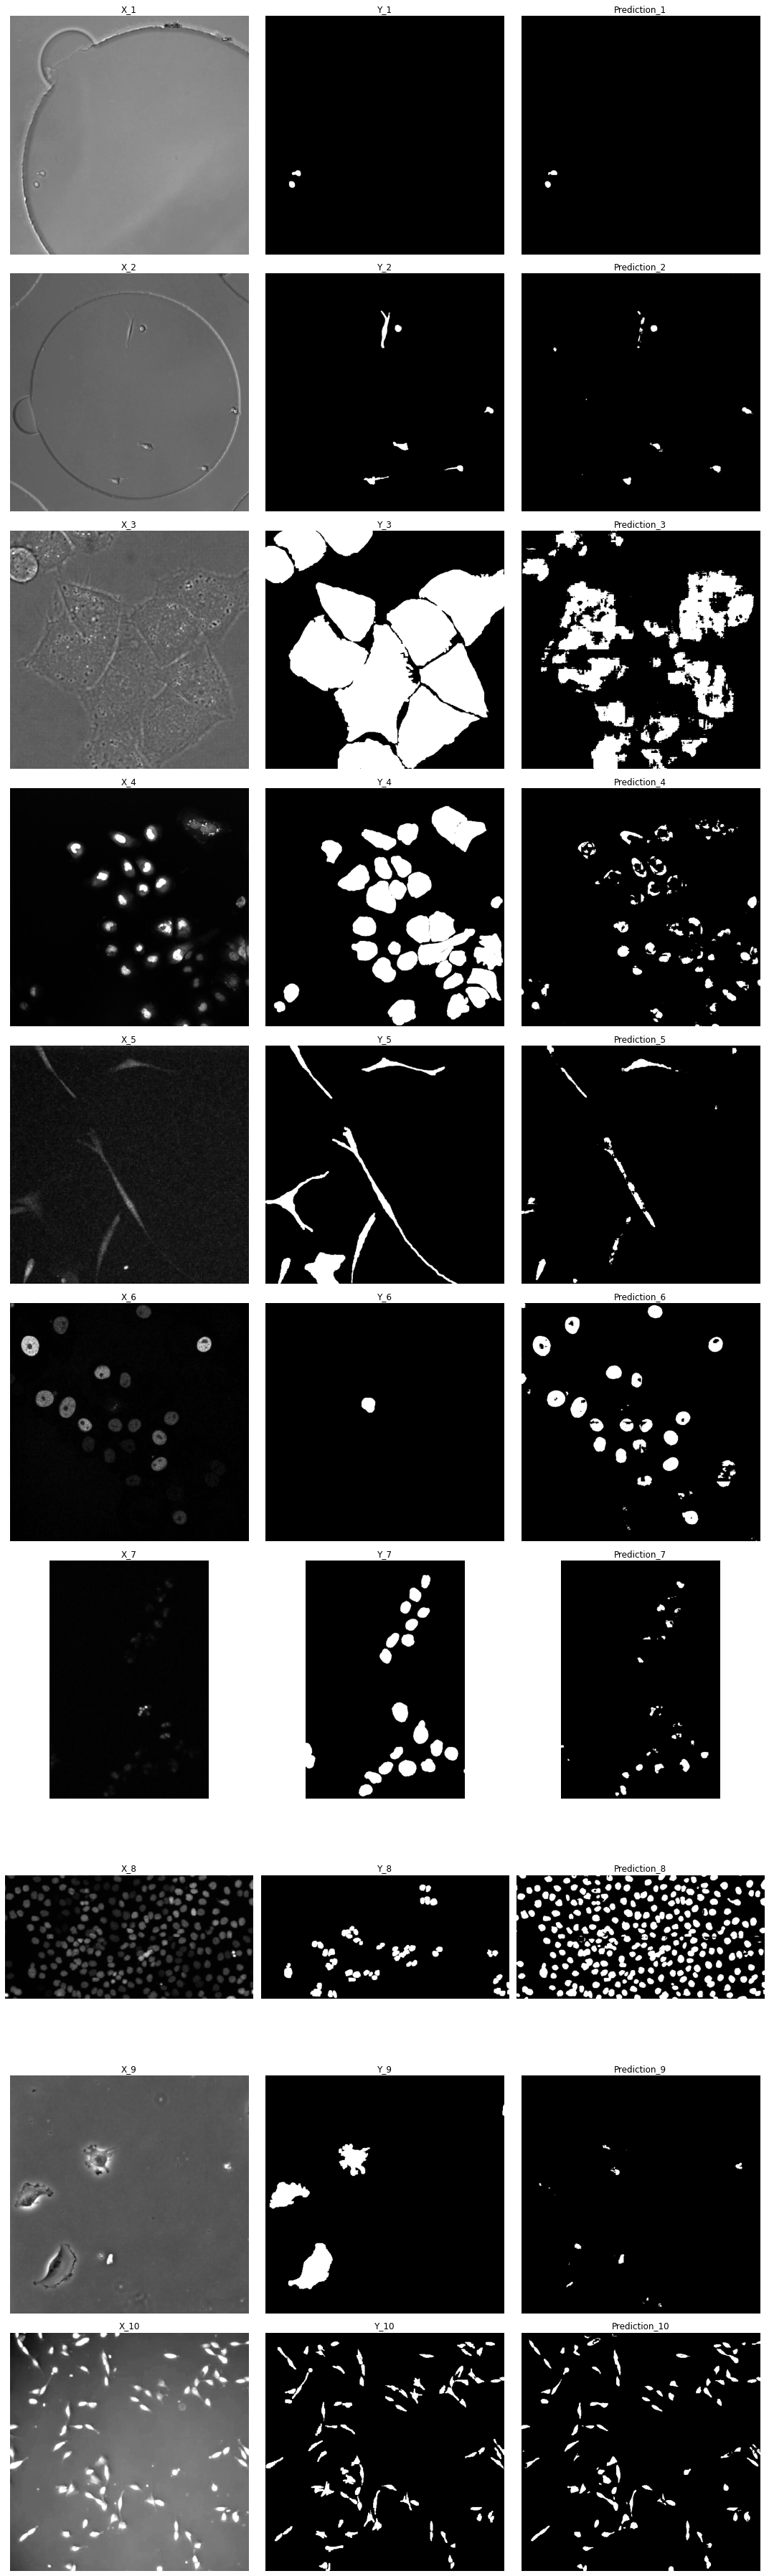

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/Processed_ST_256/"
model_name = "processed_st_images_256_model_2"
patch_size = 256

array, labels = conductBulkPrediction(random_gt_x_paths, 
                                      random_gt_y_paths,
                                      patch_size = patch_size,
                                      path = path,
                                      model_name = model_name,
                                      threshold = 0.5
                                      )

location = "/content/drive/MyDrive/COMP700_Images/Matplotlib_Figures/UNET_Model_Predictions_Processed/"

save2DPlot(array, labels, location, model_name + "_predictions.png", figsize=(15,50))

Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 665ms/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 1s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 2s 2s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 938ms/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 1s/step
Patchify process starting!
Patchify process complete!
1/1 [==============================] - 1s 661ms/step
Patchify process starting!
Patchify process complete!
1

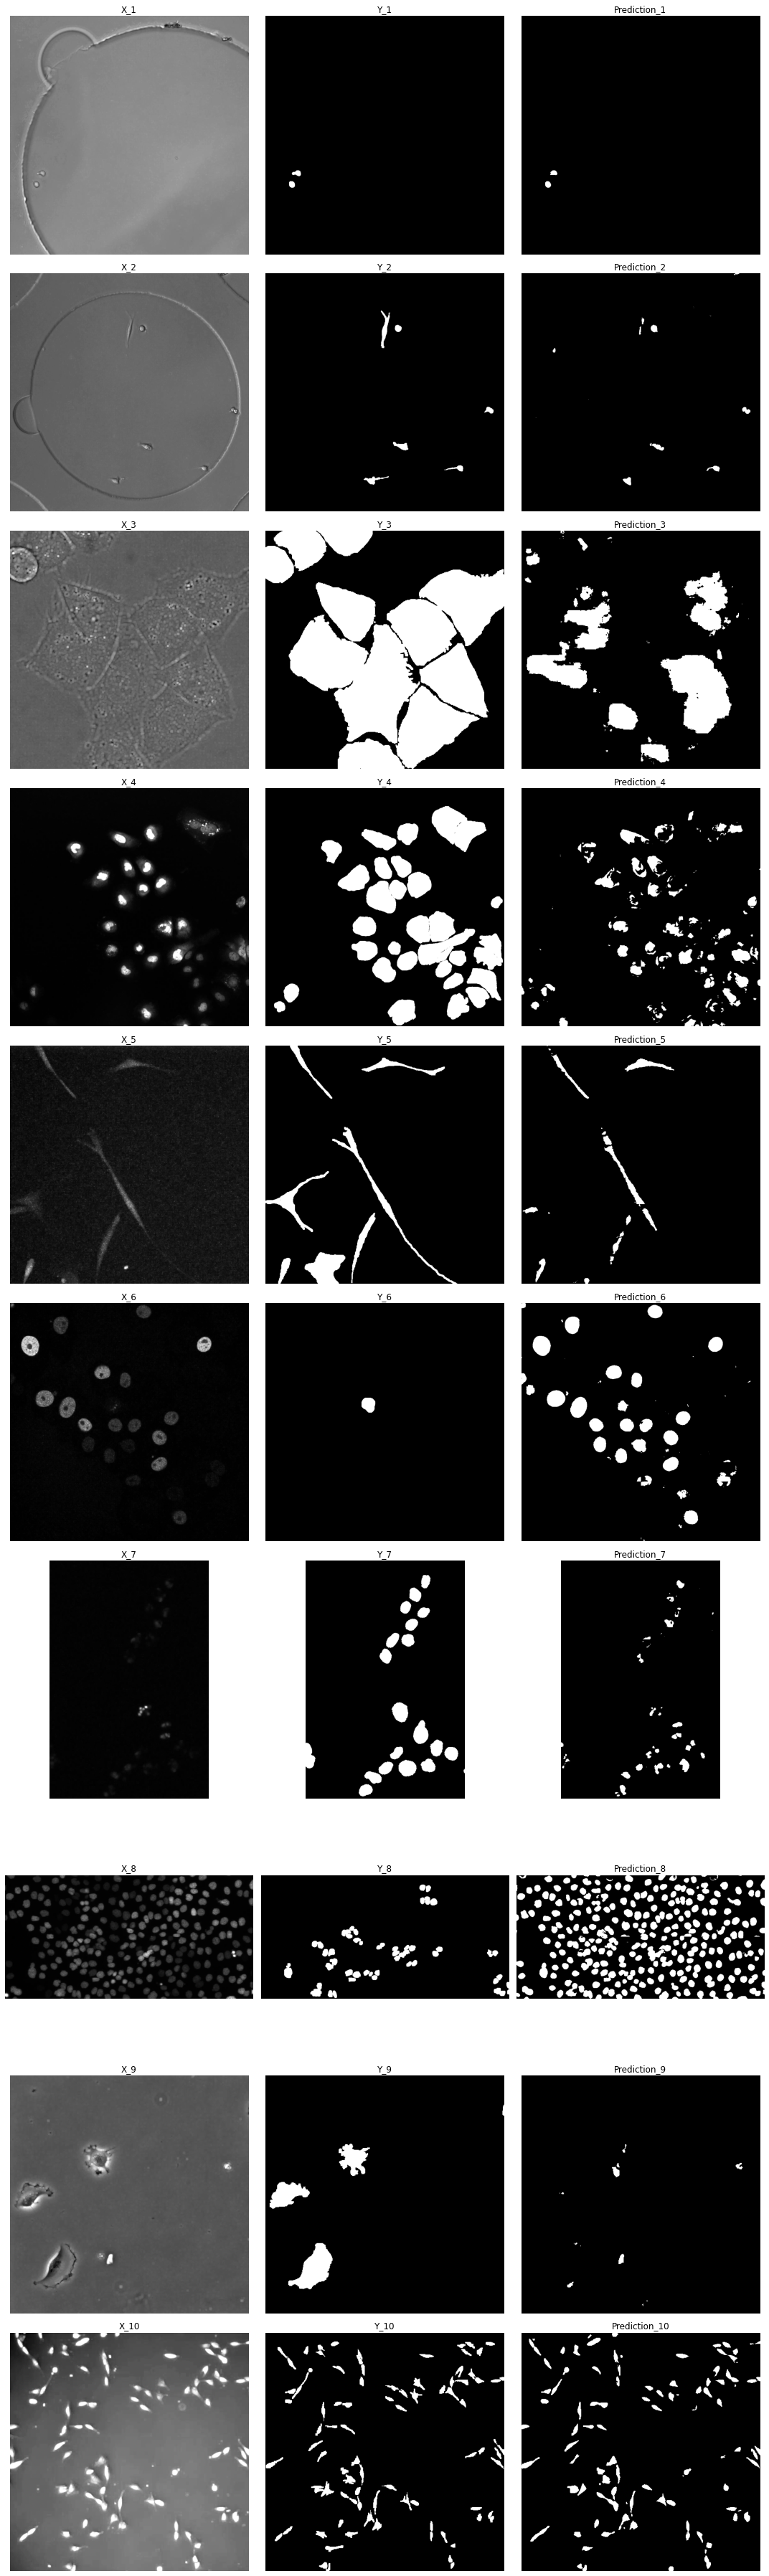

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/Processed_ST_256/"
model_name = "processed_st_images_256_model_3"
patch_size = 256

array, labels = conductBulkPrediction(random_gt_x_paths, 
                                      random_gt_y_paths,
                                      patch_size = patch_size,
                                      path = path,
                                      model_name = model_name,
                                      threshold = 0.5
                                      )

location = "/content/drive/MyDrive/COMP700_Images/Matplotlib_Figures/UNET_Model_Predictions_Processed/"

save2DPlot(array, labels, location, model_name + "_predictions.png", figsize=(15,50))

# Conclusion

We identified at the top of this document that:

| Dataset | Model name                  | Patch Size | Mean IoU Score | Observations  |
|---------|-----------------------------|------------|----------------|--------------|
| GT      | UNET_Model_Dimension_256_1  | 256        | 0.306474       | Fuzzy |
| GT      | UNET_Model_Dimension_256_2  | 256        | 0.285340       | Mixed |
| GT      | UNET_Model_Dimension_256_3  | 256        | 0.343469       | Okay  |
|         |                             |            |                |       |
| ST      | UNET_Model_Dimension_256_1  | 256        | 0.641061       | Decent |
| ST      | UNET_Model_Dimension_256_2  | 256        | 0.706629       | Excellent|
| ST      | UNET_Model_Dimension_256_3  | 256        | 0.709928       | Excellent|

After considering the 6 matplotlib figures, we can see the following:



| Dataset | Model name                  | Patch Size | Observations  |
|---------|-----------------------------|------------|---------------|
| GT      | UNET_Model_Dimension_256_1  | 256        | Mixed - Some datasets are missing predictions |
| GT      | UNET_Model_Dimension_256_2  | 256        | Mixed - Petri Dish emerges for early models|
| GT      | UNET_Model_Dimension_256_3  | 256        | Fair, crisp boundaries - but partially fragmented |
|         |                             |            |               |
| ST      | UNET_Model_Dimension_256_1  | 256        | Fair         |
| ST      | UNET_Model_Dimension_256_2  | 256        | Fair          |
| ST      | UNET_Model_Dimension_256_3  | 256        | Excellent     |


# Overall Neural Network Reflection

After comparing the results from notebook 013, the best models appear to be the following:

| Dataset        | Model Name                 | Patch Size | Observations |
|----------------|----------------------------|------------|--------------|
| GT - Raw       | UNET_Model_Dimension_256_3 | 256        | Decent       |
| ST - Raw       | UNET_Model_Dimension_256_3 | 256        | Excellent    |
| GT - Processed | UNET_Model_Dimension_256_3 | 256        | Fair, crisp boundaries - but partially fragmented       |
| ST - Processed | UNET_Model_Dimension_256_3 | 256        | Excellent    |



In the next notebook, those 4 models will be loaded and used to compare the results for each dataset